#Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

#Config

In [8]:
# Add your input path
labeled_path = "../data/labels.parquet"

#Loading Dataset

In [19]:
dataset = pd.read_parquet(labeled_path)
dataset.head()

,Location,Date,Demand
0,1,2023-01-01,40.0
1,1,2023-01-02,31.0
2,1,2023-01-03,27.0
3,1,2023-01-04,7.0
4,1,2023-01-05,15.0


#Generate temporary predicted Data

In [5]:
def create_sample_prediction(dataset):
    predicted_demand = dataset.Demand.shift(1)
    predicted_data = pd.DataFrame(dataset[['Location', 'Date']])
    predicted_data['Demand'] = predicted_demand
    return predicted_data


In [6]:
predicted_data = create_sample_prediction(dataset)
predicted_data = predicted_data.dropna()
predicted_data.head()

,Location,Date,Demand
1,1,2023-01-02,40.0
2,1,2023-01-03,31.0
3,1,2023-01-04,27.0
4,1,2023-01-05,7.0
5,1,2023-01-06,15.0


##calculate accuracy functions

In [61]:
# fix_inf_val will add to numerator and denumerator to prevent having the inf value
def calculate_accuracy_mape(actual_data, predicted_data, fix_inf_val = 1000):
    locations = pd.DataFrame(actual_data['Location'].unique(), columns=['Location'])
    loc_accuracies = pd.DataFrame(columns=['Location', 'accuracy_mape'])
    # iterate over location to calculate mape for each
    for loc_id in locations['Location']:
        actual_demand, predicted_demand = actual_data.loc[actual_data['Location']==loc_id].Demand, predicted_data.loc[predicted_data['Location']==loc_id].Demand
        error = (np.abs(actual_demand-predicted_demand)+fix_inf_val)/(actual_demand+fix_inf_val)
        error *= 100
        mape = pd.DataFrame({"Location": [loc_id], "accuracy_mape": [np.sum(error)/len(error)]})
        loc_accuracies = pd.concat([loc_accuracies,mape])
    return loc_accuracies


In [62]:
accuracies = calculate_accuracy_mape(dataset, predicted_data).set_index('Location')
print(accuracies)


          accuracy_mape
Location               
1             98.416583
2            100.027501
3             99.985190
4             95.305727
5            100.095508
...                 ...
261           72.266573
262           50.089772
263           41.404001
264           51.605400
265           94.721360

[262 rows x 1 columns]


##Plot accuracies function

In [80]:
def plot_acc_per_loc(accuracies):
    # plt.figure(figsize=(180, 6))
    ax = accuracies.plot.bar(x='Location', y='accuracy_mape', rot=0)
    plt.xlabel('Locations')
    plt.ylabel('Accuracy(mape)')
    plt.title('Model Accuracy per Location')
    plt.legend()
    plt.show()


##Evaluate Model function

In [76]:
def evaluate_model(data, predicted_data):
    accuracy = calculate_accuracy_mape(data, predicted_data)
    plot_acc_per_loc(accuracy)
    accuracy = accuracy.set_index('Location')
    report = {
        'best_accuracy': [accuracy['accuracy_mape'].min()],
        'best_accuracy_location': [accuracy['accuracy_mape'].idxmin()],
        'worst_accuracy': [accuracy['accuracy_mape'].max()],
        'worst_accuracy_location': [accuracy['accuracy_mape'].idxmax()],
        'mean_accuracy': [accuracy['accuracy_mape'].mean()]
    }
    return(pd.DataFrame(report))
    

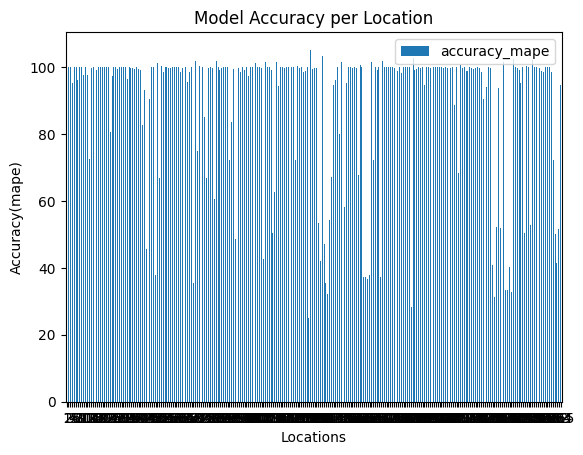

,best_accuracy,best_accuracy_location,worst_accuracy,worst_accuracy_location,mean_accuracy
0,25.030738,132,105.135993,133,89.892133


In [81]:
evaluate_model(dataset, predicted_data)